In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_excel('./data_RF_1.xlsx')
df_date = df.set_index('Date').copy()

In [3]:
target = list(df_date.columns)

In [4]:
#df_test = df_date.loc['2019-07-01':'2019-12-31']
df_train = df_date.loc['2011-02-15':'2019-06-30']

df_test = df_date.loc['2020-01-01':'2020-08-28']

In [5]:
predictors = target[0:-1]
goal = target[-1]

In [6]:
train_X = df_train[predictors]
train_y = df_train[goal]

test_X = df_test[predictors]
test_y = df_test[goal]

In [7]:
def modelfit(alg, train, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = param
        xgtrain = xgb.DMatrix(train[predictors].values, label=train[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=param['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds)
        xgb_param['n_estimators']=cvresult.shape[0]
        alg.set_params(**xgb_param)
    
    #Fit the algorithm on the data
    alg.fit(train[predictors], train[target],eval_metric='auc')
        
    #Predict training set:
    train_predictions = alg.predict(train[predictors])
    train_predprob = alg.predict_proba(train[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(cvresult.shape[0])
    print("Accuracy : %.4g" % metrics.accuracy_score(train[target].values, train_predictions))
    # print("AUC Score (Train): %f" % metrics.roc_auc_score(train[target], train_predprob))
                    
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [8]:
param = {}

param['eta'] = 0.1
param['n_estimators'] = 300
param['max_depth'] = 5
param['min_child_weight'] = 1
param['gamma'] = 0
param['subsample'] = 0.8
param['colsample_bytree'] = 0.8
param['objective'] = 'multi:softmax'
param['scale_pos_weight'] = 1
param['num_class'] = 3

In [9]:
xgb1 = XGBClassifier(**param)

[19:05:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:05:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:05:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators, scale_pos_weight } might not be used.

  This may not 

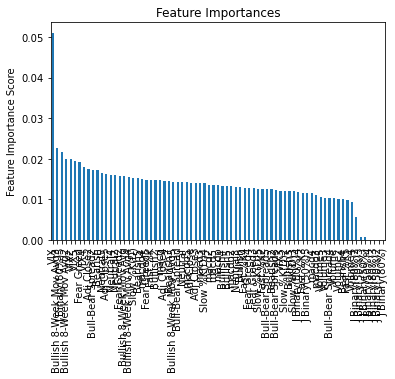

In [10]:
modelfit(xgb1, df_train, predictors, goal)

In [11]:
pred = xgb1.predict(test_X)
accuracy = accuracy_score(test_y, pred)
print('XGBoost 정확도: {:.4f}'.format(accuracy))

XGBoost 정확도: 0.5928


In [15]:
pred[1]

1

In [16]:
test_y[1]

1

In [17]:
count_up = 0
count_down = 0
count_box = 0

match_up = 0
match_down = 0
match_box = 0

for i in range(0,len(pred)):
    if pred[i] == test_y[i]:
        if pred[i] == 2:
            match_up += 1
            count_up += 1
        elif pred[i] == 1:
            match_box += 1
            count_box += 1
        else:
            match_down += 1
            count_down += 1
    else:
        if pred[i] == 2:
            count_up += 1
        elif pred[i] == 1:
            count_box += 1
        else:
            count_down += 1

In [19]:
match_up/count_up

0.5128205128205128

In [20]:
match_box/count_box

0.6111111111111112

In [21]:
match_down/count_down

1.0

In [93]:
def param_test(original_param, test_param, train = df_train, predictors = predictors, target = goal):
    gsearch = GridSearchCV(estimator = XGBClassifier(**original_param), param_grid = test_param, scoring='f1_macro',n_jobs=-1,iid=False, cv=5)
    gsearch.fit(train[predictors],train[target])
    print(gsearch.best_params_)

In [94]:
adj_param = param
adj_param['n_estimators'] = 171

In [95]:
test_param = {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}
param_test(adj_param, test_param)

C:\Users\JIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:25:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'max_depth': 7, 'min_child_weight': 5}


In [96]:
test_param = {'max_depth':[5,6,7,8,9],'min_child_weight':[3,4,5,6,7]}
param_test(adj_param, test_param)

C:\Users\JIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:26:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'max_depth': 7, 'min_child_weight': 4}


In [97]:
adj_param['max_depth'] = 7
adj_param['min_child_weight'] = 4

In [98]:
test_param = {'gamma':[i/100 for i in range(0,100)]}
param_test(adj_param, test_param)

C:\Users\JIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:29:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'gamma': 0.96}


In [99]:
adj_param['gamma'] = 0.96

In [100]:
test_param = {'colsample_bytree':[i/10.0 for i in range(0,10)], 'subsample':[i/10.0 for i in range(0,10)]}
param_test(adj_param, test_param)

C:\Users\JIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:31:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'colsample_bytree': 0.2, 'subsample': 0.1}


In [101]:
test_param = {'colsample_bytree':[i/100.0 for i in range(10,30)], 'subsample':[i/100.0 for i in range(0,20)]}
param_test(adj_param, test_param)

C:\Users\JIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:33:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'colsample_bytree': 0.27, 'subsample': 0.02}


In [102]:
adj_param['colsample_bytree'] = 0.27
adj_param['subsample'] = 0.02

In [103]:
test_param = {'reg_alpha':[0.00001,0.0001,0.001,0.01, 0.1, 1, 100]}
param_test(adj_param, test_param)

C:\Users\JIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:33:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'reg_alpha': 1e-05}


In [104]:
test_param = {'reg_alpha':[i/1000000 for i in range(0,100)]}
param_test(adj_param, test_param)

C:\Users\JIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:34:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'reg_alpha': 0.0}
